## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [3]:
from IPython.display import Audio, display
from tqdm.auto import tqdm

import numpy as np
import torch
import whisper
import datasets

import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.eval_dataset_name_to_dataset_group import EVAL_DATASET_NAME_TO_DATASET_GROUP

device = torch.device('mps')
sns.set_theme(context="paper", style="ticks")

/opt/homebrew/Caskroom/miniforge/base/envs/mlmi-dissertation-new/lib/python3.10/site-packages/whisper/timing.py:58: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def backtrace(trace: np.ndarray):


## User input

## Load model

In [4]:
# Load the Whisper model
model = whisper.load_model("tiny")

## Load dataset

In [5]:
dataset_name = "ami_10h"

ds_group = EVAL_DATASET_NAME_TO_DATASET_GROUP[dataset_name]()

if dataset_name == "librispeech_dummy":
    ds = ds_group.str2dataset["librispeech_dummy"]
    ds = ds.map(lambda x: {"text": x.lower()}, input_columns=["text"])
elif dataset_name in ["ami", "ami_10h"]:
    ds = ds_group.str2dataset["ami"]
    ds = ds.map(lambda x: {"text": x.lower()}, input_columns=["text"])
else:
    raise ValueError()

Found cached dataset ami (/Users/Tony/.cache/huggingface/datasets/edinburghcstr___ami/ihm/0.0.0/0d128d0aa8145d0f16f3d5b4da86c5d5759dbe9e8f947fda04b25edb56442bd5)
Loading cached processed dataset at /Users/Tony/.cache/huggingface/datasets/edinburghcstr___ami/ihm/0.0.0/0d128d0aa8145d0f16f3d5b4da86c5d5759dbe9e8f947fda04b25edb56442bd5/cache-c16355b1f1ecefce.arrow


In [6]:
# Fill `list_idx_hallucination` according to previous analysis:
list_idx_hallucination = [38, 223, 227, 602, 789, 852, 1146]

ds_hallucinations = ds.select(indices=list_idx_hallucination)

In [7]:
results = []
references = []
list_audio = []

for sample in tqdm(ds_hallucinations, total=ds_hallucinations.num_rows):
    results.append(model.transcribe(sample["audio"]["array"].astype(np.float32),
                                    language="en",
                                    temperature=0.0,
                                    word_timestamps=True))
    references.append(sample["text"].lower())
    list_audio.append(sample["audio"])

  0%|          | 0/7 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/mlmi-dissertation-new/lib/python3.10/site-packages/whisper/transcribe.py:114: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/opt/homebrew/Caskroom/miniforge/base/envs/mlmi-dissertation-new/lib/python3.10/site-packages/whisper/transcribe.py:114: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [8]:
from typing import Dict, Any
def count_overlaps(result: Dict[str, Any]) -> int:
    counter = 0
    for segment in result["segments"]:
        for w1, w2 in zip(segment["words"], segment["words"][1:]):
            if w1["end"] > w2["start"]:
                counter += 1
    return counter

overlaps = [count_overlaps(result) for result in results]

Reference:  but well whatever it was last week then
Prediction:   But... I mean, this week's only two days all. Well, whatever it was last week, then.

Number of overlaps: 0


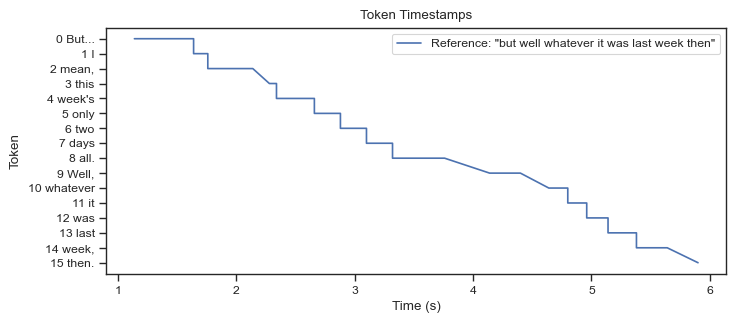

Reference:  what's you what would you prefer
Prediction:   What's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your

Number of overlaps: 0


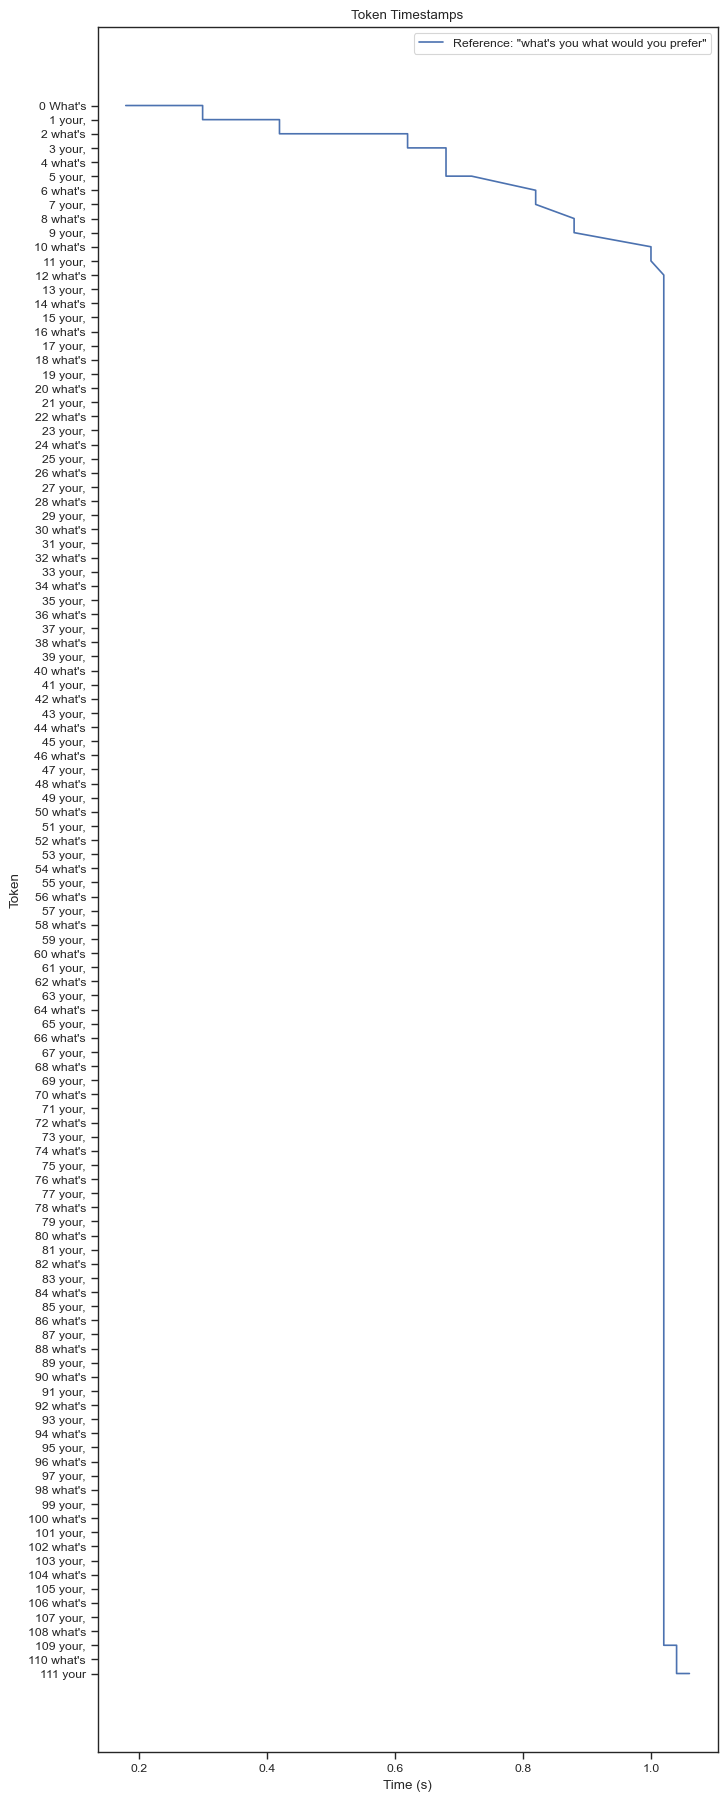

Reference:  well uh that was i guess
Prediction:   Well, that was what they said that, yes.

Number of overlaps: 0


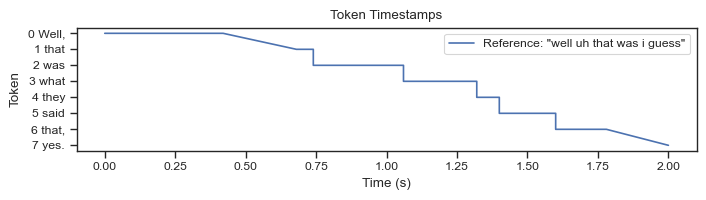

Reference:  three is alright
Prediction:   three, three, all right.

Number of overlaps: 0


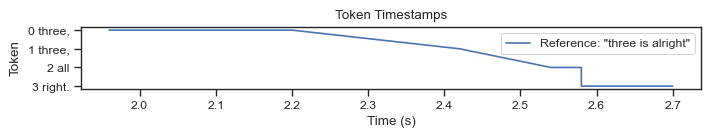

Reference:  i don't know
Prediction:  

Number of overlaps: 0


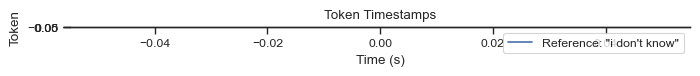

Reference:  files everywhere
Prediction:   I'll see you guys in the next video.

Number of overlaps: 0


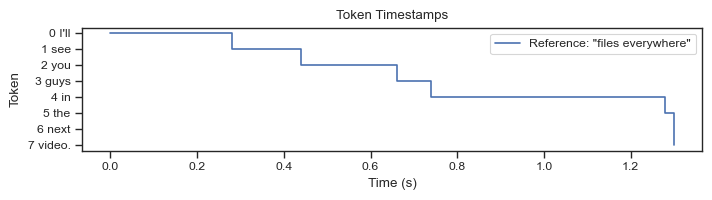

Reference:  yeah yeah but um i don't know about you but uh usually in windows right click doesn't do anything does it
Prediction:   Yeah, yeah, but I don't know about Uber. Usually in Windows, right click. Doesn't do anything, doesn't it?

Number of overlaps: 0


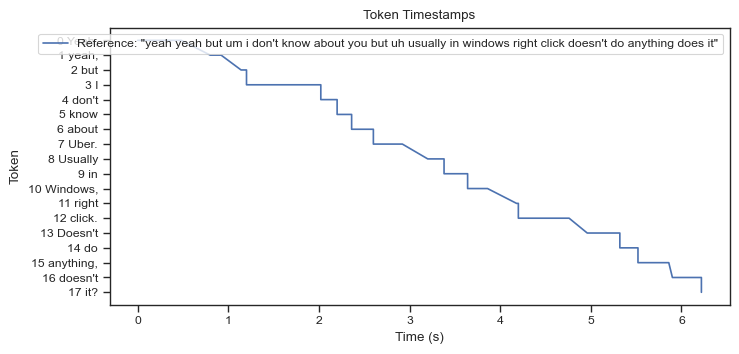

In [11]:
for audio, result, ref, n_overlaps in zip(list_audio, results, references, overlaps):
    # Load Audio player:
    display(Audio(data=audio["array"], rate=audio["sampling_rate"]))
    print
    
    # Print the transcribed text and word timestamps
    print("Reference: ", ref)
    print("Prediction: ", result["text"])
    print()
    
    # Print overlaps:
    print(f"Number of overlaps: {n_overlaps}")
     
    # Plot the token timestamps
    timestamps = []
    tokens = []
    counter = 0
    for segment in result["segments"]:
        for word in segment["words"]:
            timestamps.append(word["start"])
            timestamps.append(word["end"])
            tokens.append(str(counter) + word["word"])
            tokens.append(str(counter) + word["word"])
            counter += 1
    plt.figure(figsize=(8, len(tokens)*0.1))
    plt.plot(timestamps[::-1], tokens[::-1], label=f'Reference: "{ref}"')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Token")
    plt.title("Token Timestamps")
    plt.show()